# DNDS6013 Scientific Python: 8th Class
## Central European University, Winter 2019/2020

Instructor: Márton Pósfai, TA: Luis Natera Orozco

Emails: posfaim@ceu.edu, natera_luis@phd.ceu.edu



## Today's plan
* Continue network analysis with Networkx
* Community detection

Submit your solutions to the [slack channel](http://sp2020winter.slack.com).


## Final project plans

* Keep it simple, so that you have a complete project to submit before the deadline
* You need a self-conatained notebook (detailed explanations using markdown cells, all code runs without error) that contains all the listed requirements.
* It is okay if you get negative results.
* If you have questions or you need help to move forward: contact us

## Next homework

* Due 2 weeks from now
* More complex than the last one, so start working on time
* This will be the last set

## Why networks?

A network (or graph) is a set of nodes (or vertices) connected by a set of links (or edges). Many complex systems can be represented as networks:

<img src="http://posfaim.web.elte.hu/example_nets.png" alt="networks" style="width:75%;">

moleculas in a cell, critical infrastructure, organizations,...

[Index of Complex Networks](https://icon.colorado.edu/): A repository containing more than 5000 networks from various sources.

## Network science:
* networks = common language to describe some aspects of these systems
* What is their structure? Why? What are the consequences of the structure?
* very different systems, but some common properties


[ref1](https://www.nature.com/articles/nature24056), [ref2](https://www.facebook.com/notes/facebook-engineering/visualizing-friendships/469716398919), [ref3](https://ieeexplore.ieee.org/abstract/document/6065003)

## Network analysis with python
* `networkx`, implemented in python -> very portable
* `igraph`, implemented in C -> faster than networkx; has interface in python, R and C
* `graph-tool`, implemented in C, not for Windows, hardest to install; multicore support; strong Bayesian community detection methods

In [3]:
import networkx as nx

import matplotlib.pyplot as plt
import numpy as np

#import warnings
#warnings.filterwarnings('ignore')

### Zachary's Karate Club network 

W. W. Zachary mapped out the friendships between the members of a karate club.

Ref: W. W. Zachary, An information flow model for conflict and fission in small groups, Journal of Anthropological Research 33, 452-473 (1977)

Let's load it and review a few things from last week.

In [4]:
G=nx.read_edgelist("zachary_edgelist.txt",nodetype=int)
print("Number of nodes:", G.number_of_nodes() )
print("Number of egdes:", G.number_of_edges() )

Number of nodes: 34
Number of egdes: 78


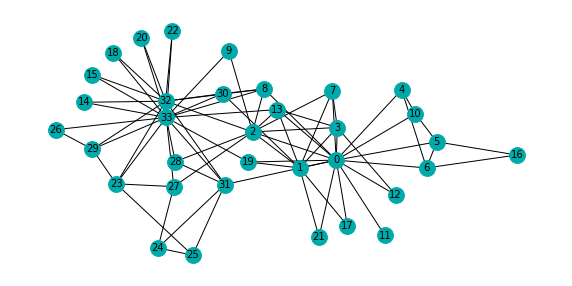

In [5]:
pos = nx.kamada_kawai_layout(G) #dynamical model for node positions

pos = {key:(value[1],value[0]) for key, value in pos.items()}

plt.figure(figsize=(10,5))
nx.draw_networkx_nodes(G, pos, node_size=250, node_color="#00aaaa") #draw nodes
nx.draw_networkx_edges(G, pos, edgelist=G.edges()) #draw edges
nx.draw_networkx_labels(G, pos, font_size=10) #draw labels

plt.axis('off');

## Exercise

Who are the best connected nodes? Which two nodes have the maximum degree?

<details><summary><u>Hint.</u></summary>
<p>

You can get the nodes degree using the `G.degree()` function. Make sure you know what `G.degree()` returns!

</p>
</details>

<details><summary><u>Solution.</u></summary>
<p>


```python
degs = G.degree() 
print("Top two nodes: ", sorted(degs,key=lambda x:x[1],reverse=True)[:2])
```

    
</p>
</details>

### Why is Zachary's karate club interesting?

During the study, a conflict developed between the the instructor (node 0) and the administrator (node 33). The conflict culminated in the splinter of the club into two parts.

**Can we predict where the split will happen based on the network structure only?**

## Node attributes

In [6]:
instr_side = [3,13,1,0,7,21,19,17,12,11,6,16,5,4,10]
admin_side = [2,28,24,27,32,33,29,23,30,8,22,20,18,15,14,25,31,26,9]

#set a node attribute
G.nodes[0]['side']=0
print(G.nodes[0])

#set multiple node attributes with a dictionary
dict = {node:{"side":0} for node in instr_side}
dict.update({node:{"side":1} for node in admin_side})
print(dict)
nx.set_node_attributes(G,dict)
print(G.nodes[33])

{'side': 0}
{3: {'side': 0}, 13: {'side': 0}, 1: {'side': 0}, 0: {'side': 0}, 7: {'side': 0}, 21: {'side': 0}, 19: {'side': 0}, 17: {'side': 0}, 12: {'side': 0}, 11: {'side': 0}, 6: {'side': 0}, 16: {'side': 0}, 5: {'side': 0}, 4: {'side': 0}, 10: {'side': 0}, 2: {'side': 1}, 28: {'side': 1}, 24: {'side': 1}, 27: {'side': 1}, 32: {'side': 1}, 33: {'side': 1}, 29: {'side': 1}, 23: {'side': 1}, 30: {'side': 1}, 8: {'side': 1}, 22: {'side': 1}, 20: {'side': 1}, 18: {'side': 1}, 15: {'side': 1}, 14: {'side': 1}, 25: {'side': 1}, 31: {'side': 1}, 26: {'side': 1}, 9: {'side': 1}}
{'side': 1}


## Exercise

In the network plot, change the color of the nodes to represent which side they chose after the split.

Bonus: change the node size to be proportional to their number of friends.

<details><summary><u>Hint.</u></summary>
<p>

When plotting the network, we set the color of all nodes with the `color=#00aaaa` argument, to individually set the color of nodes use `color=colors` where `colors` is a list.
</p>
</details>

<details><summary><u>Solution.</u></summary>
<p>


```python
colors = ["#00aaaa" if G.nodes[node]['side']==0 else "#aa00aa" for node in G.nodes()]
sizes = [k*50.+100 for idx, k in G.degree()]

plt.figure(figsize=(10,5))
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors) #draw nodes
nx.draw_networkx_edges(G, pos, edgelist=G.edges()) #draw edges
nx.draw_networkx_labels(G, pos, font_size=10) #draw labels

plt.axis('off');
```

    
</p>
</details>

### Where will the network break?

Intuition: where the fewest number of links hold it together.

One of the shortest paths between nodes 0 and 33: [0, 8, 33]
edges in shortest paths: [(0, 8), (8, 33)]


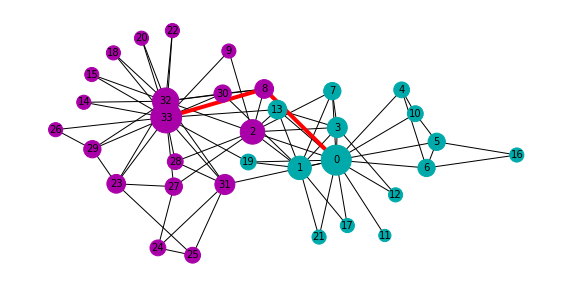

In [7]:
node1 = 0
node2 = 33

path = nx.shortest_path(G,node1,node2)
print("One of the shortest paths between nodes %d and %d:"%(node1,node2),path)

l = len(path)
path_edges = [(path[i],path[i+1]) for i in range(l-1)]
print("edges in shortest paths:", path_edges)

colors = ["#00aaaa" if G.nodes[node]['side']==0 else "#aa00aa" for node in G.nodes()]
sizes = [k*50.+100 for idx, k in G.degree()]

plt.figure(figsize=(10,5))
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors) #draw nodes
nx.draw_networkx_edges(G, pos, edgelist=G.edges()) #draw edges
nx.draw_networkx_edges(G, pos, edgelist=path_edges,edge_color='#ff0000',width=4) #draw edges
nx.draw_networkx_labels(G, pos, font_size=10) #draw labels

plt.axis('off');

### Idea

Let's remove the edge that has the most shortest paths traversing it.

**Betweenness centrality**:
$$b(e)= \frac{2}{N(N-1)}\sum_{st}\frac{\sigma_{st}(e)}{\sigma_{st}},$$
where $\sigma_{st}$ is the total number of shortest paths from node $s$ to node $t$ and $\sigma_{st}(e)$ is the number of those paths that pass through $e$.

Let's calculate and visualize edge betweenness in the karate club:

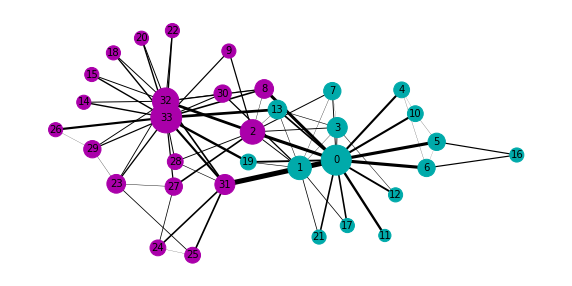

In [8]:
betw = nx.edge_betweenness_centrality(G)
widths = [40*betw[e] for e in G.edges()]

plt.figure(figsize=(10,5))
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors) #draw nodes
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=widths) #draw edges
nx.draw_networkx_labels(G, pos, font_size=10) #draw labels

plt.axis('off');

## Exercise

Write a function that takes a network as input and returns the edge with the highest betweenness.

<details><summary><u>Hint.</u></summary>
<p>

The `nx.edge_betweenness_centrality(G)` returns a dictionary, while `max()` finds the maximum of a list (or other iterable objects). Use `betw.items()` to transform a dictionary into a list containing `(key,value)` tuples.
    
</p>
</details>

<details><summary><u>Hint 2.</u></summary>
<p>
Don't forget to use to use a lambda function when searching for the maximum betweenness.
</p>
</details>

In [10]:
def max_betw_edge(G):
    betw = nx.edge_betweenness_centrality(G)
    maxe = max(betw.items(), key=lambda x:x[1])

    return maxe[0]

print(max_betw_edge(G))

(0, 31)


<details><summary><u>Solution.</u></summary>
<p>


```python
def max_betw_edge(G):
    betw = nx.edge_betweenness_centrality(G)
    maxe = max(betw.items(), key=lambda x:x[1])
    
    return maxe[0]
    
print(max_betw_edge(G))
```

    
</p>
</details>

Let's remove this edge and plot the network to show that we are successful.

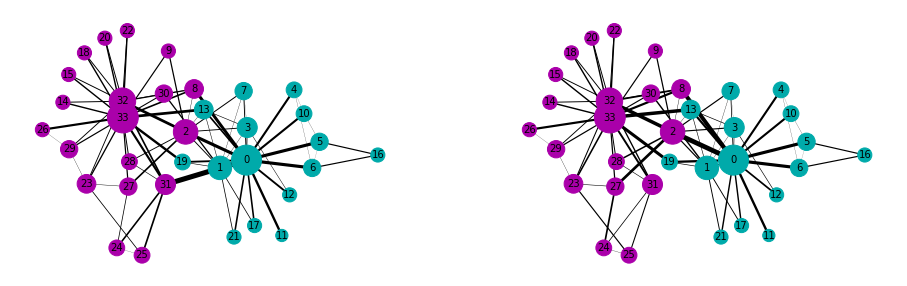

In [11]:
G2 = G.copy() #copy, so we also keep the original

maxe = max_betw_edge(G2)
G2.remove_edge(maxe[0],maxe[1])


#networkx plots using matplotlib -> we can use all functions of the module
fig, axes = plt.subplots(1,2,figsize=(16,5))

plt.sca(axes[0])
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors) #draw nodes
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=widths) #draw edges
nx.draw_networkx_labels(G, pos, font_size=10) #draw labels

plt.axis('off');

#recalculate betweenness in new network
betw = nx.edge_betweenness_centrality(G2)
widths2 = [40*betw[e] for e in G2.edges()]

plt.sca(axes[1])
nx.draw_networkx_nodes(G2, pos, node_size=sizes, node_color=colors) #draw nodes
nx.draw_networkx_edges(G2, pos, edgelist=G2.edges(), width=widths2) #draw edges
nx.draw_networkx_labels(G2, pos, font_size=10) #draw labels

plt.axis('off');

Repeat this until network falls into two pieces. How can we tell?

### Connected components

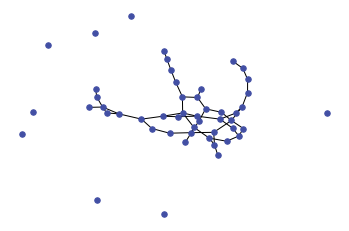

{0, 1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49}
{6}
{8}
{10}
{26}
{29}
{30}
{37}
{48}
Is the ER network connected: False
Number of connected components: 9
Is the karate club connected: True
Number of connected components: 1


In [12]:
# Erdős-Rényi network model = randomly connect node pairs with probability p
ER_graph=nx.erdos_renyi_graph(50, 0.04)
nx.draw_networkx(ER_graph, with_labels=False,node_size=30, node_color="#424FA4")
plt.axis('off')
plt.show()

for c in nx.connected_components(ER_graph):
    print(c)
    
print("Is the ER network connected:", nx.is_connected(ER_graph))
print("Number of connected components:",nx.number_connected_components(ER_graph))
print("Is the karate club connected:", nx.is_connected(G))
print("Number of connected components:",nx.number_connected_components(G))


A list of colors for later plots.

In [13]:
colorlist = [
        "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
]

## Exercise

Put everything together to find the two sides of the network
1. Calculate edge betweenness
2. Remove edge with maximum betweenness
3. Repeat steps 1 and 2 until network falls apart
4. Plot network to see if we recovered the two factions

<details><summary><u>Hint.</u></summary>
<p>

Instead of the usual `for` loop, use the `while` loop instead:
    
```python
while condition:
    statements
```
    
</p>
</details>

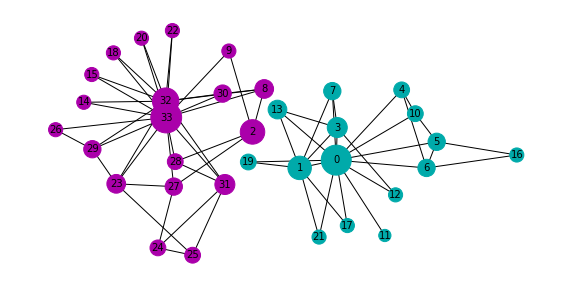

In [14]:
G2 = G.copy()
while nx.number_connected_components(G2)!=2:
    maxe = max_betw_edge(G2)
    G2.remove_edge(maxe[0],maxe[1])

plt.figure(figsize=(10,5))
nx.draw_networkx_nodes(G2, pos, node_size=sizes, node_color=colors) #draw nodes
nx.draw_networkx_edges(G2, pos, edgelist=G2.edges()) #draw edges
nx.draw_networkx_labels(G2, pos, font_size=10) #draw labels

plt.axis('off'); 

<details><summary><u>Solution.</u></summary>
<p>


```python
G2 = G.copy()
while nx.number_connected_components(G2)!=2:
    maxe = max_betw_edge(G2)
    G2.remove_edge(maxe[0],maxe[1])
    
plt.figure(figsize=(10,5))
nx.draw_networkx_nodes(G2, pos, node_size=sizes, node_color=colors) #draw nodes
nx.draw_networkx_edges(G2, pos, edgelist=G2.edges()) #draw edges
nx.draw_networkx_labels(G2, pos, font_size=10) #draw labels

plt.axis('off'); 
```

    
</p>
</details>

## Community detection

What we just implemented is the Girvan-Newman community detection algorithm.

[**Communities**](https://en.wikipedia.org/wiki/Community_structure): densely connected subnetworks.

Example: collaboration network of scientist at the Sante Fe Research Institute
<img src="https://www.pnas.org/content/pnas/99/12/7821/F6.medium.gif" alt="a Network" style="width:30%;">

We can repeat continue to remove edges until the network falls apart into 2,3,4,... pieces to get community structure at different scales.

How do we know which is the best partition?

[**Modularity**](https://en.wikipedia.org/wiki/Modularity_(networks)):
Measures how different the community structure is compared to randomly selecting neighbors.

$$Q = \frac{1}{2L}\sum_{v,w}\left(A_{vw}-\frac{k_vk_w}{2L}\right)\delta(c_v,c_w)$$
* $L$: number of links
* $A_{vw}$: adjacency matrix, 1 if $v$ and $w$ are connected, 0 otherwise
* $k_v$: degree of node $v$
* $\delta(c_v,c_w)$: 1 if $v$ and $w$ is in the same community, 0 otherwise

Bottom line:
* **Close to 0 if not better than random partition.**
* **Close to 1 if strong community.**

[Ref](https://www.pnas.org/content/99/12/7821.short)

Let's plot modularity as a function of the number of communities.

In [ ]:
communities_generator = nx.algorithms.community.girvan_newman(G)
commlist = []
numcomm = []
Qs = []
for comm in communities_generator:
    commlist.append(comm)
    numcomm.append(len(comm))
    Qs.append(nx.community.modularity(G,comm))

bestcomm = max(numcomm,key=lambda x:Qs[x-2])
print("Best community division:", bestcomm)
print(commlist[bestcomm-2])
plt.plot(numcomm,Qs)
plt.plot([bestcomm],[Qs[bestcomm-2]],'ro')
plt.xlabel("Modularity")
plt.ylabel("Number of communities");

## Alternative community finding methods

Girvan-Newman algorithm was a hugely influential method, because it itroduced novel thinking. However, it quickly became outdated: it is slow and doesn't find the best partitions in terms of modularity.

Many algorithms:
* Divisive (Grivan-Newman) -- agglomerative (Louvain, hierarchical clustering)
* Spectral
* Dynamics-based (random walks, InfoMap)
* Overlapping communities
* Edge communities
* Statistical inference (stochastic block models, `graph-tool` is a powerful python package)

Everyone uses Zachary's Karate Club to demonstrate that their method works. (+ other datasets)

-> [Zachary's Karate Club CLUB](https://networkkarate.tumblr.com/): trophy gets passed on to first person to mention it at a conference

<img src="https://66.media.tumblr.com/2eadbea4b57e1b91c69082ad1af2b712/tumblr_mo149hnujs1sqr43do1_1280.jpg" alt="a Network" style="width:30%;">

## Louvain method

Popular agglomerative method for very large networks.
1. Start from each node in its own community
2. Pick node and put it in one community with one of its neighbors so that modularity is maximized
3. Repeat 1-2 until modularity can't be increased any more
4. Next level: create coarse-grained network: nodes represent communities
5. Repeat steps 1-3

Algorithm generates a community partition on each level, we can select the best one based on modularity.

<img src="http://networksciencebook.com/images/ch-09/figure-9-37.jpg" alt="a Network" style="width:60%;">

[Ref](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008/meta)

Not implemented in `networkx`, but available as a [separate package](https://github.com/taynaud/python-louvain). Install it:

In [ ]:
conda install -c conda-forge python-louvain

A list of colors for later plots.

In [ ]:
colorlist = [
        "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
]

Usage:

In [ ]:
import community

partition = community.best_partition(G)
print(partition)
print("Best modularity found w Louvain:", community.modularity(partition,G))
print("Best modularity found w Girvan-Newman:",max(Qs))

plt.figure(figsize=(10,5))
louvain_colors = [colorlist[partition[node]] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=louvain_colors) #draw nodes
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=widths) #draw edges
nx.draw_networkx_labels(G, pos, font_size=10); #draw labels

plt.axis('off');

## Political blog network

Let's try something larger:
* nodes = US political blogs
* links = blogs linking each other

(Originally the network is directed, here we ignore that.)

### Exercise

Load the network from the `polblogs-undirected.gml` file and print out the number of nodes and the average degree of the network.

This time the network is stored in a GML (graph modeling language), which contains additional information about the nodes. Use the `nx.read_gml()` function, read the documentation if needed.

<details><summary><u>Hint.</u></summary>
<p>

The average degree of an undirected network can be calculated as $\frac{2L}{N}$, where $L$ is the number of links and $N$ is the number of nodes.

    
</p>
</details>

<details><summary><u>Solution.</u></summary>
<p>


```python
Gpol = nx.read_gml("polblogs-undirected.gml")
print("Number of nodes:", Gpol.number_of_nodes())
print("Average degree: %.2f"%(2*Gpol.number_of_edges()/Gpol.number_of_nodes())) 
```

    
</p>
</details>

Generating a layout takes takes longer:

In [ ]:
pos = nx.kamada_kawai_layout(Gpol) #dynamical model for node positions
pos = {key:(value[1],value[0]) for key, value in pos.items()}

### Exercise

1. Use the Louvain algorithm to find a community partition of the network
2. Print out the total number of the communities and their sizes. 
3. Plot the network using the node positions we just calculated coloring each node according to their community membership.

Can you guess what the communities are?

<details><summary><u>Hint.</u></summary>
<p>

The `community.best_partition(Gpol)` returns a dictionary whose keys are the nodes and values index the communities starting from $0$ to $C-1$, where $C$ is the total number of communities.
    
</p>
</details>

<details><summary><u>Solution.</u></summary>
<p>


```python
partition = community.best_partition(Gpol)
C = max(partition.values())+1
print("Number of communities:", C)
memberships = list(partition.values())
comm_sizes = [memberships.count(c) for c in range(C)]
print("Community sizes:", comm_sizes)

polcolors = [colorlist[partition[node]] for node in Gpol.nodes()]
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(Gpol, pos, node_size=10, node_color=polcolors) #draw nodes
nx.draw_networkx_edges(Gpol, pos, edgelist=Gpol.edges()) #draw edges

plt.axis('off');
```

    
</p>
</details>

The gml file contains a node attribute `value`:

In [ ]:
Gpol.nodes['100monkeystyping.com']

Meaning:
* `value`==0 -> liberal
* `value`==1 -> conservative

Do these correspond to the communities we found?

### Exercise

Calculate the average `value` within each community. Average close to 1 will indicate an overwhelmingly conservative community, average close to 0 a liberal community.

<details><summary><u>Hint.</u></summary>
<p>

Remember, the `community.best_partition(Gpol)` returns a dictionary whose keys are the nodes and values index the communities starting from $0$ to $C-1$, where $C$ is the total number of communities. One possibility is to iterate through the community indices using:
```python
for c in range(C):
    #create a list containing values of nodes in community c
    #calculate average of this list
```
    
</p>
</details>

<details><summary><u>Solution.</u></summary>
<p>


```python
#solution 1
for c in range(C):
    values = []
    for node in Gpol.nodes:
        if partition[node]==c:
            values.append(Gpol.nodes[node]['value'])
    avg = np.mean(values)
    print(c, avg)

#solution 2
avg   = np.zeros(C,dtype=float)
for node in Gpol.nodes:
    avg[partition[node]] += Gpol.nodes[node]['value']
comm_sizes = np.array([memberships.count(c) for c in range(C)])
avg /= comm_sizes
print(avgvalue)

```

    
</p>
</details>

## Statistical inference of communities

* Define a probabilistic generative model for networks with communities
* Fit the model to data
* Advantage: statistical significance of communities, principled model comparison
* In the early days of community detection, only worked for small networks
* Modern approaches allow even (empirical) Bayesian inference for large networks.
* `graph-tool` package for python: [find out more here](https://graph-tool.skewed.de/static/doc/demos/inference/inference.html)

## Additional exercises

### Degree distribution

Plot the degree distribution of the political blogs network. Try both linear and log scale.

<details><summary><u>Solution.</u></summary>
<p>


```python
degs = [ deg for node, deg  in Gpol.degree()]
numbins = max(degs)-min(degs)+1
hist, bin_edges= np.histogram(degs, bins=numbins, density=True)
fig, axes = plt.subplots(1,2,figsize=(10,4))

plt.sca(axes[0])

plt.plot(bin_edges[:-1],hist,'o-')
plt.xlabel(r'$k$', fontsize=10)
plt.ylabel(r'$P(k)$', fontsize=10)

plt.sca(axes[1])
plt.loglog(bin_edges[:-1],hist,'o-')
plt.xlabel(r'$k$', fontsize=10)
plt.ylabel(r'$P(k)$', fontsize=10);

```

    
</p>
</details>

### Network models -- Erdős-Rényi

Generate an Erdős-Rényi network with the same number of nodes and average degree as the politcal blogs network.
Plot its degree distribution. How does it compare to the degree distirbution of the political blogs network.

<details><summary><u>Solution.</u></summary>
<p>


```python
N = Gpol.number_of_nodes()
L = Gpol.number_of_edges()
ER_graph=nx.erdos_renyi_graph( N, 2*L/N**2.)

print("average degree in blog network", 2*L/N)
print("average degree in ER network", 2*ER_graph.number_of_edges()/ER_graph.number_of_nodes())

degs = [ deg for node, deg  in ER_graph.degree()]
numbins = max(degs)-min(degs)+1
hist, bin_edges= np.histogram(degs, bins=numbins, density=True)
fig, axes = plt.subplots(1,2,figsize=(10,4))

plt.sca(axes[0])

plt.plot(bin_edges[:-1],hist,'o-')
plt.xlabel(r'$k$', fontsize=10)
plt.ylabel(r'$P(k)$', fontsize=10)

plt.sca(axes[1])
plt.loglog(bin_edges[:-1],hist,'o-')
plt.xlabel(r'$k$', fontsize=10)
plt.ylabel(r'$P(k)$', fontsize=10);
```

    
</p>
</details>

### Network models -- Barabási-Albert

Generate a Barabási-Albert network with the same number of nodes and approximately the same average degree as the political blogs network. (In BA models, we add $m$ links with each node, where $m$ is an integer.)
Plot its degree distribution. How does it compare to the degree distirbution of the political blogs network.

<details><summary><u>Solution.</u></summary>
<p>


```python
N = Gpol.number_of_nodes()
L = Gpol.number_of_edges()
BA_graph = nx.barabasi_albert_graph(N,round(L/N))

print("average degree in blog network", 2*L/N)
print("average degree in ER network", 2*BA_graph.number_of_edges()/BA_graph.number_of_nodes())

degs = [ deg for node, deg  in BA_graph.degree()]
numbins = max(degs)-min(degs)+1
hist, bin_edges= np.histogram(degs, bins=numbins, density=True)
fig, axes = plt.subplots(1,2,figsize=(10,4))

plt.sca(axes[0])

plt.plot(bin_edges[:-1],hist,'o-')
plt.xlabel(r'$k$', fontsize=10)
plt.ylabel(r'$P(k)$', fontsize=10)

plt.sca(axes[1])
plt.loglog(bin_edges[:-1],hist,'o-')
plt.xlabel(r'$k$', fontsize=10)
plt.ylabel(r'$P(k)$', fontsize=10);

```

    
</p>
</details>